In [1]:
import numpy as np
import pandas as pd
import os
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
from datetime import timedelta
from time import time, sleep
from datetime import datetime
from tqdm import tqdm, tqdm_notebook
from datetime import datetime
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from keras.models import Input, Model, model_from_json
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Reshape, Concatenate, Bidirectional
from keras import backend as K
from numpy.random import seed
from tensorflow import set_random_seed

Using TensorFlow backend.


# Dataset import

In [2]:
#Retrieves the import filepath.
def CreatePathName(dir1='', dir2='', dir3='', dir4='', filename=''):
    '''Directory generator function.

    Args:
        dir1: Parent direrctory name if exists.
        dir2: First Child direrctory name if exists.
        dir3: Second Child direrctory name if exists.
        dir4: Third Child direrctory name if exists.
        filename: Filname  if exists with the extension.

    Returns:
        Absolute path.
        
    Revision:
        February 24, 2020 created (Edgar Khachatryan)
    '''
    path = os.path.join(os.path.dirname(os.path.realpath(__name__)), dir1, dir2, dir3, dir4, filename)
    return path

In [3]:
#Joins filepath with filename and changes the working directory.
csvFilesPath = CreatePathName(os.pardir, 'input')
os.chdir(csvFilesPath)
print(os.getcwd())

C:\DATA\DATA\ANN_python\Projects_to_Investigate\HEC\input


In [4]:
#Printing first 2 and last row of df.
dfDUQ = (pd.read_csv(filepath_or_buffer=os.listdir(csvFilesPath)[5], 
                                     index_col=0, 
                                     header=0, 
                                     parse_dates=True)).sort_index()
print("Dataframe {} \n {} \n\n has {} rows.".format("dfDUQ", dfDUQ.iloc[[0,1,-1]], dfDUQ.shape[0]))

Dataframe dfDUQ 
                      DUQ_MW
Datetime                   
2005-01-01 01:00:00  1364.0
2005-01-01 02:00:00  1273.0
2018-08-03 00:00:00  1656.0 

 has 119068 rows.


# Preprocessing

## Rename the column to "Cons".

In [5]:
#Rename the column of all dfs to Cons.
dfDUQ.rename(columns=lambda x: 'Cons', inplace=True)

## Check negative or zero values.

In [6]:
def checkNegativeOrZeroValues (df, column):
    '''
    Descriptioin:
        Prints the number of zero or negative values, and returns the index of such row in case of non-zero result.
        If no zero value, returns nothing.
        
    Args:
        df: Data Frame to look in.
        column: the column in which the 0 or negative value is checked. 
    
    Returns:
        list of 0 indices in df. 
        
    Revisions:
        E.Khachatryan 2020-06-06
    '''
    indicesOfZeros = []
    noOfZeros = len(df.loc[df[column]<=0, column].values.tolist())
    if noOfZeros==0:
        return print("There is no 0 or negative value in the df")
    elif noOfZeros>0:
        print("There are '{}' negative or zero values in the df".format(noOfZeros))
        indicesOfZeros = df.index[df[column] <= 0].values.tolist()
        return indicesOfZeros
    else:
        raise Exception("Number of rows couldn't be negative: {}".format(noOfZeros))
         
########################################################################################
def checkMissingValues(df):
    '''
    Descriptioin:
        Prints the number of missing (null) values, and returns the index of such row in case of non-zero result.
        If no zero value, returns nothing.
        
    Args:
        df: Data Frame to look in.
            
    Returns:
        list of 0 indices in df. 
        
    Revisions:
        E.Khachatryan 2020-06-07   
    '''
    nullRows = df.isnull().any(axis=1)
    sumOfNullContainingRows = sum(nullRows)
    if sumOfNullContainingRows == 0:
        print("Data Frame has no missing values.")
    else:
        print("Data Frame has {} missing value(s).".format(sumOfNullContainingRows))
        return df[nullRows].index.values

In [7]:
checkNegativeOrZeroValues(dfDUQ, 'Cons')
checkMissingValues(dfDUQ)

There is no 0 or negative value in the df
Data Frame has no missing values.


## Added weekday+hour column named "WeekDayHour"

In [8]:
#Adding day of week and day of week and hour.
# def getWeekDay(timestamp):
#     weekday = timestamp.weekday()
#     return weekday

def addHoursToWDays(timestamp):
    weekdayHour = str(timestamp.weekday()) + '_' + timestamp.strftime("%H")
    return weekdayHour

In [9]:
weekDayHour = []
for i in range(dfDUQ.shape[0]):
    weekDayHour.append(addHoursToWDays(dfDUQ.index[i]))
dfDUQ['WeekDayHour'] = weekDayHour
print(dfDUQ.head())

                       Cons WeekDayHour
Datetime                               
2005-01-01 01:00:00  1364.0        5_01
2005-01-01 02:00:00  1273.0        5_02
2005-01-01 03:00:00  1218.0        5_03
2005-01-01 04:00:00  1170.0        5_04
2005-01-01 05:00:00  1166.0        5_05


## Added average consumption column named "meanCons"

Each value of "meanCons" column is calculated based on the average of all consumption levels recorderd that day of week and that hour of day accross first year. 

In [10]:
#Defining the function to add the average consumption based on weekday+hour combination.
def addAvgConsUsingWeekdayHour(dataFrame, grByCriteriaCol, sourceCol, targetCol, RowsToCount, roundLevel=1):
    if (grByCriteriaCol == sourceCol or grByCriteriaCol==targetCol):
        raise Exception('Group by Criteria Column cannot be the same as Source Column or Target Column.')
    dataFrame[targetCol] = dataFrame.loc[:,grByCriteriaCol]\
                                            .replace(dataFrame.iloc[:RowsToCount,:]\
                                                     .groupby(grByCriteriaCol)[sourceCol]\
                                                         .mean()\
                                                             .round(roundLevel)\
                                                                 .to_dict())

#Adding meanCons column that contains the average consumption by weekday and hour.    
Rows = 24*365
addAvgConsUsingWeekdayHour(dfDUQ, 'WeekDayHour', 'Cons', 'meanCons', Rows)
print(dfDUQ.head())

                       Cons WeekDayHour  meanCons
Datetime                                         
2005-01-01 01:00:00  1364.0        5_01    1483.9
2005-01-01 02:00:00  1273.0        5_02    1420.0
2005-01-01 03:00:00  1218.0        5_03    1375.9
2005-01-01 04:00:00  1170.0        5_04    1354.1
2005-01-01 05:00:00  1166.0        5_05    1346.5


## Added the difference of logarithm of "Cons" and logarithm of  "meanCons" columns

In [11]:
#Creating a function to standardize the target column.
def addStandardizedColumn(dataFrame, sourceCol, meanCol, targetCol):
    dataFrame[targetCol] = (np.log(dataFrame.loc[:, sourceCol]) - np.log(dataFrame.loc[:, meanCol]))
    
addStandardizedColumn(dfDUQ, 'Cons', 'meanCons', 'logdiffConsAndMeanCons')

(dfDUQ.head())

,Cons,WeekDayHour,meanCons,logdiffConsAndMeanCons
Datetime,,,,
2005-01-01 01:00:00,1364.0,5_01,1483.9,-0.084252
2005-01-01 02:00:00,1273.0,5_02,1420.0,-0.109281
2005-01-01 03:00:00,1218.0,5_03,1375.9,-0.121898
2005-01-01 04:00:00,1170.0,5_04,1354.1,-0.146133
2005-01-01 05:00:00,1166.0,5_05,1346.5,-0.143930


In [12]:
#########################

In [13]:
# def reverseStandardizedColumn(dataFrame, sourceCol, meanCol, targetCol):
#     #dataFrame[targetCol] = np.exp((dataFrame.loc[:, sourceCol]) + np.log(dataFrame.loc[:, meanCol]))
#     dataFrame[targetCol] = np.exp((dataFrame.loc[:, sourceCol]) + np.log(dataFrame.loc[:, meanCol]))
    
# reverseStandardizedColumn(dataFrame=dfDUQ, sourceCol='logdiffConsAndMeanCons', meanCol='meanCons', targetCol='reversed')
# dfDUQ.head()

In [14]:
##################

## Added exploratory visualizations

In [15]:
def createPlotConsumption (x_col, y_col, variable_label, chart_title, x_label, y_label):
    '''
    DESCRIPTION:
        Create a plot for total consumption.

    Args:
        x_col: X axes
        y_col: Y axes
        variable_label: The name of target variable.
        chart_title: Title of the chart.
        x_label: x axis label name.
        y_label: y axis label name.

    Returns:
        A list of Line2D objects representing the plotted data.
    '''

    # Create a plot.
    sns.set()
    figTotalCons = plt.figure(figsize = (18,6))
    sns.lineplot(x=x_col,
                 y=y_col,
                 label=variable_label,
                 legend="full")

    # Add labels.
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)
    
    plt.ylim(ymin=0, ymax=1.1*max(y_col))

    # Add a title.
    chart_title = chart_title
    plt.title(chart_title, fontsize=20, fontweight="bold")
    return plt

In [16]:
def createPlotConsumption (x_col, y_col1, variable_label1, chart_title, x_label, y_label, 
                           y_col2=None, low_10=None, up_90=None, variable_label2=None):
    '''
    DESCRIPTION:
        Create a plot for total consumption.

    Args:
        x_col: X axes
        y_col: Y axes
        variable_label: The name of target variable.
        chart_title: Title of the chart.
        x_label: x axis label name.
        y_label: y axis label name.

    Returns:
        A list of Line2D objects representing the plotted data.
    '''

    # Create a plot.
    sns.set()
    figTotalCons = plt.figure(figsize = (18,6))
    sns.lineplot(x=x_col, y=y_col1, label=variable_label1, legend="full")
    if y_col2 is not None:
        sns.lineplot(x=x_col, y=y_col2, label=variable_label2, legend="full")
        plt.ylim(ymin=0, ymax=1.15*max(max(y_col1), max(up_90)))
        plt.fill_between(x_col, low_10, up_90, alpha=0.2, 
                 edgecolor='#1B2ACC', facecolor='#089FFF', linewidth=1, linestyle='dashdot', antialiased=True)
    else:
        plt.ylim(ymin=0, ymax=1.15*max(y_col1))

    # Add labels.
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)
    
    # Add a title.
    chart_title = chart_title
    plt.title(chart_title, fontsize=20, fontweight="bold")
    return plt

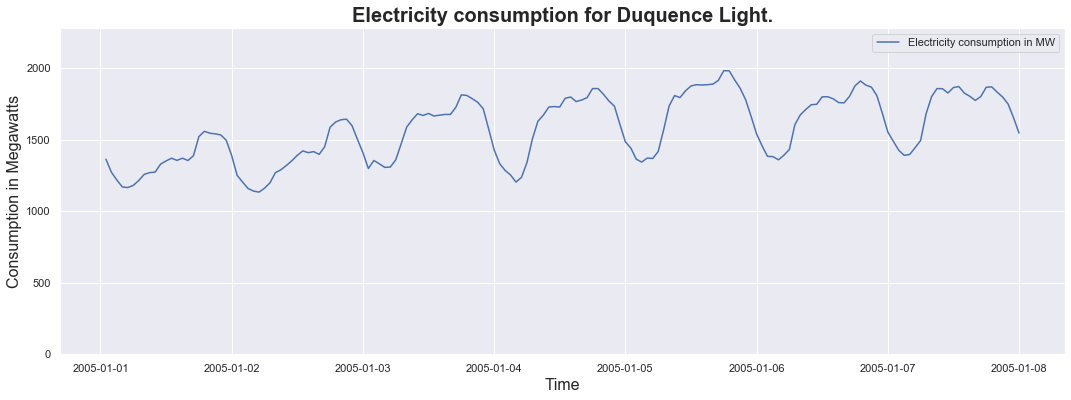

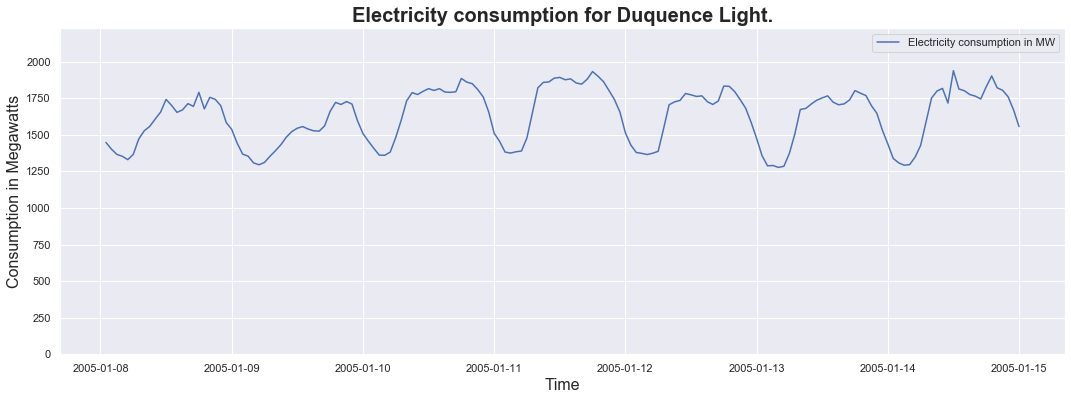

In [17]:
for i in range(2):
    createPlotConsumption(dfDUQ.iloc[24*7*i:24*7*i+24*7].index, 
                      dfDUQ.iloc[24*7*i:24*7*i+24*7, 0], 
                      "Electricity consumption in MW", 
                      "Electricity consumption for Duquence Light.",
                      "Time",
                      "Consumption in Megawatts",  y_col2=None, variable_label2=None)
plt.show()

## Added model preprocessing

In [18]:
#TODO: add param for range(0, numElements-totalSeqLen+1, 1). 1 should be configurable.

def generateMultiStepModelInput(dataFrame, totalSeqLen, ySeqLen, col):
    '''
    Generates X and Y sets from dataframe's column.
    
    Args:
        dataFrame: Data Frame to look at.
        totalSeqLen: The predictor and response variables sequence length combined.
        ySeqLen: The response variable sequence lengt.
        col: The column to look at.
        
    Returns:
        2 lists: 1st X list with the dimensions of: ((df total rows-totalSeqLen+1), 
                                                            totalSeqLen-ySeqLen, 
                                                            1)
                 2nd Y list with the dimensions of: ((df total rows-totalSeqLen+1),
                                                        ySeqLen)

    Revision:
        June 06, 2020 created (Edgar Khachatryan)
    '''
    dataMatrix = dataFrame[col]
    numElements = dataMatrix.shape[0]
    
    indices = dataFrame.index.values

    for _, stop in zip(range(0, numElements-totalSeqLen+1, 1), 
                       range(totalSeqLen, numElements+1, 1)):
        
        yield dataMatrix[(stop-totalSeqLen):stop-ySeqLen].values.reshape((-1,len(col))), \
              dataMatrix[stop-ySeqLen:stop].values.reshape((-1))

In [19]:
sequenceLength = 7*24

X, Y = [], []
totalSequenceLength = 5*7*24 #Total 5 weeks,use 4 weeks data to forecast 1 week foreward.
ySequenceLength = 7*24


for i in generateMultiStepModelInput(dfDUQ, totalSequenceLength, ySequenceLength, ['logdiffConsAndMeanCons']):
    x, y = i
    X.append(x)
    Y.append(y)
X = np.asarray(X)
Y = np.asarray(Y)

In [20]:
print(X.shape, Y.shape)

(118229, 672, 1) (118229, 168)


## Train-Test split

In [21]:
#Model uses 4 weeks of data (672 hours) to predict next 7 days (168 hours) of consumption.

In [22]:
trainLength = 168*52
X_Train, y_Train = X[0:trainLength], Y[0:trainLength]

In [23]:
X_Test, y_Test = X[trainLength:2*trainLength], Y[trainLength:2*trainLength]

In [24]:
print("The input shape of data is {}, {} and {}. \nThe output shape is {}, {}.".format(X_Train.shape[0], X_Train.shape[1], X_Train.shape[2],  y_Train.shape[0], y_Train.shape[1]))

The input shape of data is 8736, 672 and 1. 
The output shape is 8736, 168.


# Model Creation

In [25]:
seed(1988)
set_random_seed(1988)

In [26]:
losses = [lambda y,f: K.mean(K.maximum(0.1*(y-f), (0.1-1)*(y-f)), axis=-1), 
         lambda y,f: K.mean(K.maximum(0.5*(y-f), (0.5-1)*(y-f)), axis=-1), 
         lambda y,f: K.mean(K.maximum(0.9*(y-f), (0.9-1)*(y-f)), axis=-1)]

In [27]:
#Creating a model
# inputs = Input(shape=(X_Train.shape[1], X_Train.shape[2]))
# lstm = Bidirectional(LSTM(32, return_sequences=True, dropout=0.3))(inputs, training = True)
# lstm = Bidirectional(LSTM(16, return_sequences=False, dropout=0.3))(lstm, training = True)

# dense = Dense(50)(lstm)

# out10 = Dense(y_Train.shape[1])(dense)
# out50 = Dense(y_Train.shape[1])(dense)
# out90 = Dense(y_Train.shape[1])(dense)

# ModelDUQ = Model(inputs, [out10,out50,out90])

# ModelDUQ.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3])
# ModelDUQ.summary()

## Pretrained Model import

Training has done on 70 epochs.

In [28]:
# Change working directory to ../ModelDUQs.
ModelDUQPath = CreatePathName(os.pardir, 'Models')
os.chdir(ModelDUQPath)
print(os.getcwd())

C:\DATA\DATA\ANN_python\Projects_to_Investigate\HEC\Models


In [29]:
# # Save ModelDUQ to .json format.
# ModelDUQSaveJson = ModelDUQ.to_json()
# with open("LSTMModelDUQ.json", "w") as json:
#        json.write(ModelDUQSaveJson)

# # Save weights to HDF5
# ModelDUQ.save_weights("LSTMModelDUQWeights.h5")

# # Save the optimizer value
# optimizerWeights = getattr(ModelDUQ.optimizer, 'weights')
# weights = K.batch_get_value(optimizerWeights)
# with open('optimizerModelDUQ.pkl', 'wb') as f:
#     pickle.dump(weights, f)

In [30]:
# Load ModelDUQ from .json file.
LSTMModelDUQFile = open("LSTMModelDUQ.json", "r")
ModelDUQReader = LSTMModelDUQFile.read()
LSTMModelDUQFile.close()
ModelDUQ = model_from_json(ModelDUQReader)

# Compile the ModelDUQ and print.
ModelDUQ.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3])
ModelDUQ.summary()

# Load weights to the loadedModelDUQ from .hdf5 file to predict.
ModelDUQ.load_weights("LSTMModelDUQWeights.h5")

# Load optimizer weights to comtinue training.
ModelDUQ._make_train_function()
with open('optimizerModelDUQ.pkl', 'rb') as f:
    weightValues = pickle.load(f)
ModelDUQ.optimizer.set_weights(weightValues)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 672, 1)       0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 672, 64)      8704        input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 32)           10368       bidirectional_3[0][0]            
__________________________________________________________________________________________________
dense_5 (Dense)      

## Model training

In [31]:
#Pretrain the ModelDUQ.
# EPOCHS = 1
# history = ModelDUQ.fit(X_Train, [y_Train, y_Train, y_Train], epochs=EPOCHS, batch_size=548, verbose=2, shuffle=True)

In [32]:
###LOADED ModelDUQ QUANTILEs BOOTSTRAPPING ###
#Forecasting electricity consumption for the 3 month period.
yHat10, yHat, yHat90 = [], [], []
NN = K.function([ModelDUQ.layers[0].input, K.learning_phase()], 
                [ModelDUQ.layers[-3].output,ModelDUQ.layers[-2].output,ModelDUQ.layers[-1].output])

for i in tqdm_notebook(range(0, 100)):
    predd = NN([X_Test[0:2160], 0.5])
    yHat10.append(predd[0])
    yHat.append(predd[1])
    yHat90.append(predd[2])
    
yHat10 = np.quantile(yHat10, 0.1, axis=0)
yHat = np.asarray(yHat).mean(axis=0)
yHat90 = np.quantile(yHat90, 0.9, axis=0)

In [33]:
def reverseStandardizedValue(YTestRowIndex, YTestColIndex, 
                             XTrainShape0, XTrainShape1,
                             sourceDF, meanCol, souceVal):
    '''
    YTestRowIndex, YTestColIndex: Index of row and column, by 1 less than XTrainShape0, XTrainShape1.
    '''
    meanVal = sourceDF.loc[ sourceDF.index[ YTestRowIndex + YTestColIndex
                                           + XTrainShape0 + XTrainShape1 ],
                            meanCol ]
    
    return np.exp(souceVal + np.log(meanVal))

def returnRowIndex(YTestRowIndex, YTestColIndex, 
                   XTrainShape0, XTrainShape1,
                   sourceDF):
    index = sourceDF.index[ YTestRowIndex + YTestColIndex
                          + XTrainShape0 + XTrainShape1 
                          ]
    return index

# Returns row index from df.
# for i in range(Y.shape[0]):
#     for j in range(Y.shape[1]):
#         print(returnRowIndex(i, j, X.shape[1], dfDUQ))

# Returns row index from df.
# for i in range(Y.shape[0]):
#     for j in range(Y.shape[1]):
#         print(reverseStandardizedValue(i, j, X.shape[1], dfDUQ, 'meanCons', Y[i,j]))

In [34]:
prediction, prediction10, prediction90 = [], [], []
for i in tqdm_notebook(range(2160)):
    prediction.append([])
    prediction10.append([])
    prediction90.append([])
    for j in range(yHat.shape[1]):

        prediction[i].append(reverseStandardizedValue(i, 
                         j, 
                         X_Train.shape[0], 
                         X_Train.shape[1],  
                         dfDUQ, 
                         'meanCons', 
                         yHat[i][j]))
        
        prediction10[i].append(reverseStandardizedValue(i, 
                         j, 
                         X_Train.shape[0], 
                         X_Train.shape[1],  
                         dfDUQ, 
                         'meanCons', 
                         yHat10[i][j]))
        
        prediction90[i].append(reverseStandardizedValue(i, 
                         j, 
                         X_Train.shape[0], 
                         X_Train.shape[1],  
                         dfDUQ, 
                         'meanCons', 
                         yHat90[i][j]))

prediction = np.asarray(prediction)
prediction10 = np.asarray(prediction10)
prediction90 = np.asarray(prediction90)

In [35]:
#Create array of actual test values.
actual = []
for i in tqdm_notebook(range(2160)):
    actual.append([])
    for j in range(y_Test.shape[1]):
        actual[i].append(reverseStandardizedValue(i, 
                         j, 
                         X_Train.shape[0], 
                         X_Train.shape[1],  
                         dfDUQ, 
                         'meanCons', 
                         y_Test[i][j]))
actual = np.asarray(actual)

# # Retriveing the actual consumption data for the predicted period from dataframe.
# predStartIndex = returnRowIndex(0, 0, X_Train.shape[0], X_Train.shape[1], dfDUQ)
# predEndIndex = returnRowIndex(yHat.shape[0]-1, yHat.shape[1]-1, X_Train.shape[0], X_Train.shape[1], dfDUQ)
# actual = dfDUQ.loc[predStartIndex:predEndIndex, 'Cons'].values

In [36]:
#Create array of indices for plotting.
index = []
for i in tqdm_notebook(range(2160)):
    index.append([])
    for j in range(yHat.shape[1]):
        index[i].append(returnRowIndex(i, 
                                    j, 
                                    X_Train.shape[0], 
                                    X_Train.shape[1],  
                                    dfDUQ))
index = np.asarray(index)

In [37]:
print(prediction.shape, prediction10.shape, prediction90.shape, actual.shape, index.shape)

(2160, 168) (2160, 168) (2160, 168) (2160, 168) (2160, 168)


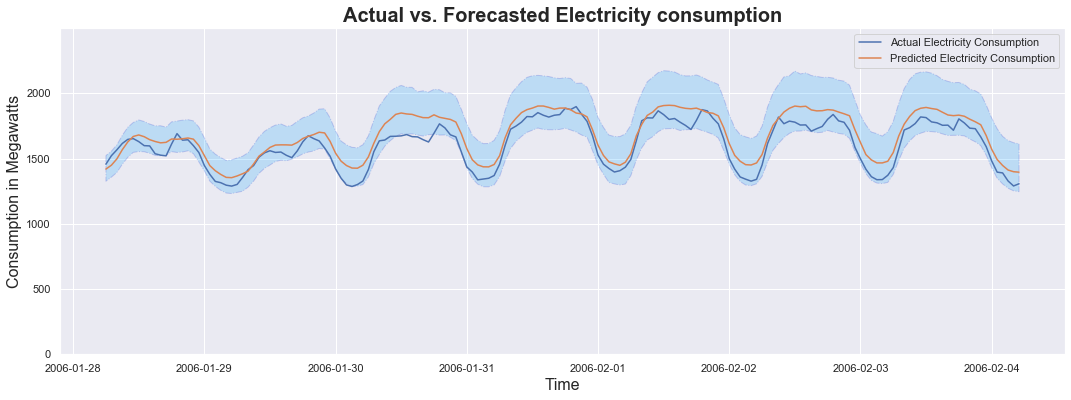

In [38]:
createPlotConsumption(index[3], actual[3], "Actual Electricity Consumption", "Actual vs. Forecasted Electricity consumption", "Time", 
                      "Consumption in Megawatts", 
                      prediction[3], prediction10[3], prediction90[3], "Predicted Electricity Consumption" )
plt.show()

#### Evaluate the ModelDUQ.

In [39]:
def MAPE(yActual, yPrediction): 
    """
    Calculates MAPE given y_true and y_pred
    """
    yActual, yPrediction = np.asarray(yActual), np.asarray(yPrediction)
    return np.mean(np.abs((yActual - yPrediction) / yActual)) * 100

In [40]:
actual.shape

(2160, 168)

In [41]:
MAPE(actual, prediction)

4.2397684361214285

In [42]:
mapes = []
for i in range(100):
    mapes.append(MAPE(actual[i], prediction[i]))

In [43]:
print("Index of MAX value: {}; MAX value: {}".format(mapes.index(max(mapes)), max(mapes)))
print("Index of MIN value: {}; MIN value: {}".format(mapes.index(min(mapes)), min(mapes)))

Index of MAX value: 7; MAX value: 5.967594909089006
Index of MIN value: 48; MIN value: 2.6283474422960547


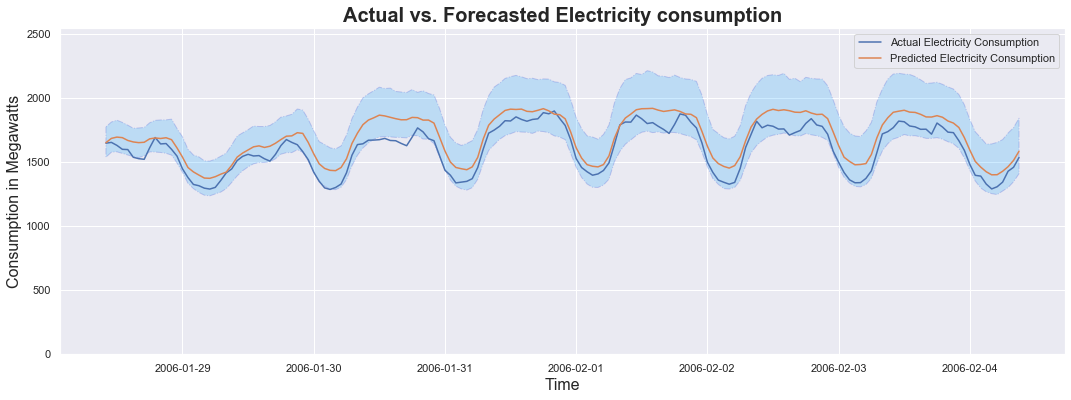

In [44]:
#Worst prediction.
createPlotConsumption(index[mapes.index(max(mapes))], actual[mapes.index(max(mapes))], 
                      "Actual Electricity Consumption", "Actual vs. Forecasted Electricity consumption", "Time", 
                      "Consumption in Megawatts", prediction[mapes.index(max(mapes))], 
                      prediction10[mapes.index(max(mapes))], prediction90[mapes.index(max(mapes))], 
                      "Predicted Electricity Consumption" )
plt.show()

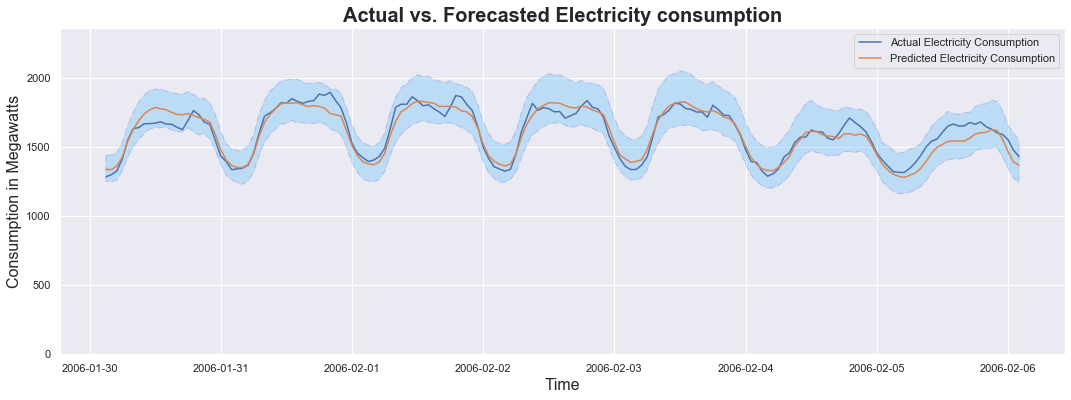

In [45]:
#Best prediction
createPlotConsumption(index[mapes.index(min(mapes))], actual[mapes.index(min(mapes))], 
                      "Actual Electricity Consumption", "Actual vs. Forecasted Electricity consumption", "Time", 
                      "Consumption in Megawatts", prediction[mapes.index(min(mapes))], 
                      prediction10[mapes.index(min(mapes))], prediction90[mapes.index(min(mapes))], 
                      "Predicted Electricity Consumption" )
plt.show()